In [337]:
from enum import Enum
import random
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import copy

from queue import PriorityQueue

In [338]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Represents the different types of Cells
class Cell(Enum):
    BLOCKED = 0
    OPEN = 1
    FIRE = 2
    BUTTON = 3

    def __eq__(self, other):
        if isinstance(other, Cell):
            return self.value == other.value
        return self.value == other
    
# Represents the Ship
class Ship: 
    def __init__(self, D, q, seed):
        self.D = D
        self.q = q
        self.seed = seed
        self.time = 0
        self.board = []
        self.open_cells = []
        self.fire_cells = []
        self.bot_location = ()
        
        self.init_board()
        self.init_bot()
        self.init_fire()
        self.init_button()
    
    def init_board(self):
        n = self.D
        random.seed(self.seed)
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # For approx. half of the dead ends, pick a random closed neighbor and open it
        for de in dead_ends:
            expand = random.randint(0, 1)
            if expand:
                r, c = de
                closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
                if closed_neighbors: # Some dead ends may no longer be dead ends after some iterations
                    rand_cell = random.choice(closed_neighbors)
                    nr, nc = rand_cell
                    self.board[nr][nc] = Cell.OPEN
                    open_cells.append((nr, nc))

        self.open_cells = open_cells

    def init_bot(self):
        self.bot_location = random.choice(self.open_cells)
    
    def init_fire(self):
        """Randomly selects a cell to catch on fire"""
        open_cell = random.choice(self.open_cells) # Choose a random cell from the open cells
        r, c = open_cell

        self.board[r][c] = Cell.FIRE  
        self.fire_cells.append(open_cell)
        self.open_cells.remove(open_cell)

    def init_button(self):
        open_cell = random.choice(self.open_cells)
        r, c = open_cell

        self.board[r][c] = Cell.BUTTON 
        self.button_location = (r, c)


    # Time Steps
    def time_step(self):
        self.advance_fire()
        self.time += 1
    
    def advance_fire(self):
        """Advances fire within a calculated probability"""
        fire_cells = self.fire_cells[:]
        
        for fc in fire_cells:
            r, c = fc
            potential_fire = self.get_neighbors(r, c, Cell.OPEN)

            for cell in potential_fire:
                nr, nc = cell
                ignite = self.ignition_probability(nr, nc)
                
                if ignite: # Ignites the cell and removes it from open cells
                    self.board[nr][nc] = Cell.FIRE
                    self.open_cells.remove(cell)
                    self.fire_cells.append(cell)

    
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D
    
    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                # print("removing {}".format(pair))
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates
    
    def validate_board(self):
        """Validates that there are no BLOCKED cells with exactly one neighbor"""
        n = self.D
        count = 0
        for i in range(n):
            for j in range(n):
                if self.board[i][j] == Cell.BLOCKED:
                    open_neighbors = self.get_neighbor_count(i, j, Cell.OPEN)
                    if open_neighbors == 1:
                        count += 1
        
        return count == 0

    def ignition_probability(self, r, c):
        """Calculate the probability that any given cell should be ignited, given the formula: 1 - (1 - q)^K"""
        q = self.q # Flammability constant
        K = self.get_neighbor_count(r, c, Cell.FIRE) # Get number of burning neighbors
        probability = 1 - ((1 - q) ** K)
        return random.uniform(0, 1) <= probability

    
    # Traversal Algorithms
    def shortest_path(self, src, dst):
        """Calculate the shortest path from SRC to DST if one exists - BFS"""
        n = self.D
        queue = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        count = 0
        while queue:
            count += 1
            coords, path = queue.pop(0)
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    queue.append(next_entry)

        return []

    def astar(self, start, goal, c=0):
        open = PriorityQueue() # fringe
        closed = set() # explored
        
        start_r, start_c = start[0], start[1]
        goal_r, goal_c = goal[0], goal[1]

        f = abs(goal_r - start_r) + abs(goal_c - start_c)
        open.put((f, (start, [start])))

        while open.qsize() != 0:
            curr = open.get()
            #print("curr", curr)
            f, vertex = curr
            coords, path = vertex

            if coords == goal:
                return path # SUCCESS
            else:
                closed.add(coords)
                
                r, c = coords
                for i in range(4):
                    nr = DY[i] + r
                    nc = DX[i] + c
                    if self.is_valid(nr, nc) and self.board[nr][nc] != Cell.BLOCKED and (nr, nc) not in closed:
                        if c >= 1: # self.board[nr][nc] == Cell.OPEN and 
                            if self.board[nr][nc] == Cell.FIRE:
                                continue
                            # check for fire
                        if c == 2:
                            if len(self.get_neighbor_count(nr, nc, Cell.FIRE)) > 0:
                                continue
                            # check for neighbor fire

                        new_path = path + [(nr, nc)]

                        g = len(new_path) - 1
                        h = abs(goal_r - nr) + abs(goal_c - nc)

                        f = g + h

                        next_entry = (f, ((nr, nc), new_path))

                        open.put(next_entry)

        return []
        

    def has_path(self, src, dst):
        """Calculate a path from SRC to DST if one exists - DFS"""
        n = self.D
        stack = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        while stack:
            coords, path = stack.pop()
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    stack.append(next_entry)

        return []
        

    # Bot methods
    def is_fail(self):
        r, c = self.button_location
        if self.board[r][c] == Cell.FIRE:
            return True
        
        r, c = self.bot_location
        if self.board[r][c] == Cell.FIRE:
            return True
        
        return False

    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        n = self.D
        copy_board = [row[:] for row in self.board]
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 2
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
                      

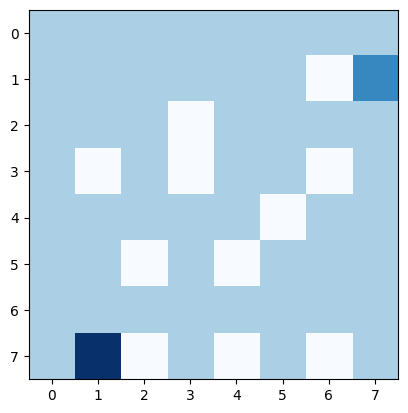

In [339]:
# Generate Ship
D = 8 # ship size
q = .95   # flammability constant
seed = 2023

ship = Ship(D, q, seed)
ship.display()

In [340]:
class Bot:
    def __init__(self, ship: Ship):
        self.ship = ship
        self.bot = ship.bot_location
        self.button = ship.button_location

    def move(self, new_location):
        self.ship.bot_location = new_location
        self.bot = self.ship.bot_location
    
    def bot_1(self):
        path = self.ship.astar(self.bot, self.button)
        if path:
            return path[1]
        return (-1, -1)

    def bot_2(self):
        path = ship.astar(self.bot, self.button, c=1)
        if path:
            return path[1]
        return (-1, -1)

    def bot_3(self):
        path = ship.astar(self.bot, self.button, c=2)
        if path:
            return path[1]
        return (-1, -1)
    
    def simulate(self, bot_query=bot_1, step_limit=-1):
        success = False

        i = 0
        while step_limit < 0 or i < step_limit:
            next = bot_query()
            print(next)

            if next == (): # no next move found
                success = False
                break
            
            else: # move bot
                self.move(next)
                if self.bot == self.button:
                    success = True
                    break

            i += 1
            ship.time_step()

            if ship.is_fail():
                success = False
                break
        
        return success, i


(1, 0)
(2, 0)
(3, 0)
(4, 0)
(4, 1)
(5, 1)
(6, 1)
(7, 1)
(True, 7)


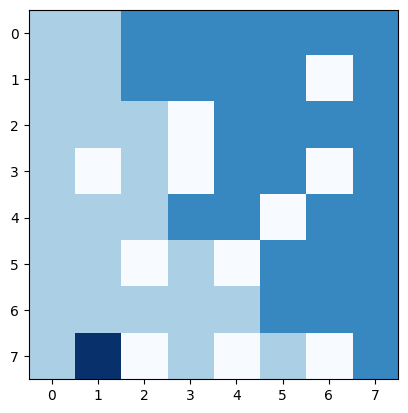

In [341]:
test_bot = Bot(ship)

#print(test_bot.query_bot_1())

result = test_bot.simulate(test_bot.bot_1)
print(result)
ship.display()

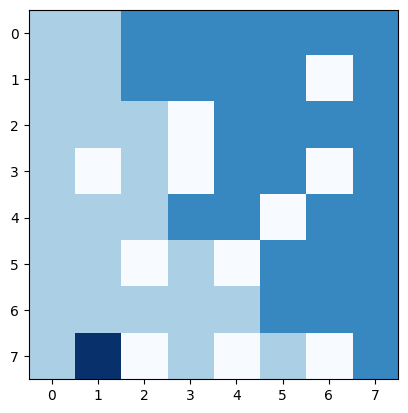

In [342]:
sorted_opens = sorted(ship.open_cells, key = lambda x : (x[0], x[1]))
a, b = sorted_opens[0], sorted_opens[-1]
#path = ship.has_path(a, b)
next = ship.shortest_path(a, b)
ship.display(next)